# Iris Classification using Fuzzy Neural Min-Max Classifier

In this tutorial, we will be talking about a basic fuzzy min-max classifier, which is first introduced by Patrick Simpson in 1992.

## Fuzzy Min-Max Classifier

We’ll take a look at this classifier in two different ways. The way this classifier is used to infer the class of a test pattern and the way this classifier neural network is trained i.e **inference** and **learning algorithm**.

### 1. Inference

![](figures/fuzzy-neural-inference.png)

Consider that we have an *n-dimensional* pattern $A_{h}$. And we have K number of discriminant functions where each discriminant function tells the class of the pattern with a confidence score between `[0, 1]`. the most confident discriminant in our inference i.e the function giving maximum value, we will consider the pattern belongs to that class.

By the way, the **discriminant function** can be understood as the **membership function**. Let the **K** discriminant functions be **K** fuzzy sets each defining the participation of the pattern in a specific class. Thus we will believe the pattern belongs to a class defined by the fuzzy set for which the pattern gives maximum **membership value**.

### 2. Hyperbox

Now before we fit this inference framework in a neural network, we need to understand one alternative representation for the fuzzy set.

Consider a 2D universe of discourse `[0, 1]`. We define a rectangle as a fuzzy set such that all the points within that box have a membership value **1**. A box is defined by its maximum point and its minimum point.

The box shown in the below figure is defined by min-pt `v=[0.2, 0.2]` and max-pt `w=[0.8, 0.8]`. This box is also a fuzzy set. And the membership value of this fuzzy set is defined such that all points inside that box have `mA(x) = 1`

![](figures/hyperbox.png)

The membership value of any point outside the box decreases (< 1) as the distance between that box and the point increases. This distance is averaged over all dimensions (in this case only 2). The membership value for such a definition of box fuzzy set is given by

![](figures/membership-value.png)

Here Ah is our n-dimensional (in our example 2D) pattern and the box Bj is also defined in n-dimensions (i.e 2 in our case)

### 3. Architecture

![](figures/nn.png)

In the neural network architecture shown above, the input nodes are placeholders for the n-dimensional input pattern. There are n input nodes for n-dimensional input space.

The next layer contains Hyperbox nodes. Each hyperbox node is defined by its min-pt and max-pt in n-dimensional space. And each hyperbox belongs to some class.

The final layer contains the class nodes. The number of nodes in this layer is equal to the number of possible classes. In the inference part of the classifier we use the output of these class nodes as the discriminant functions and the class node giving the maximum score is assumed to predict the class value of the pattern.

When considering the class node output, we consider the maximum membership value among the hyperboxes belonging to that class. The membership values given by the hyperboxes belonging to other classes are not considered.

### 4. Learning algorithm

Once we have the hyperboxes, we can use the above described method to the predict the class of the patterns. But first we need an algorithm to learn these hyperboxes based on the data we have available.

The learning algorithm can be categorised into two distinct phases — Expansion phase and Contraction phase.

#### 4.a Expansion phase:

Let $X_{h}$ be an n-dimensional training pattern belonging to class Y. The first thing we do is find the most suitable hyperbox for expansion. We take all the hyperboxes belonging to the class Y and calculate their membership values. The hyperbox with the maximum membership value is the most suitable candidate for expansion.

Let $B_{j}$ be the hyperbox most suitable for expansion. Before we expand, we need to meet the expansion criterion which is a condition defined by

![](figures/expansion-phase.png)

where θ is a hyperparameter known as the **expansion bound**. This hyperparameter controls the maximum expansion allowed for a hyperbox.

If our hyperbox satisfies the above condition then the hyperbox is expanded as follows

![](figures/expansion-phase-2.png)
![](figures/expansion-phase-3.png)

where $V_{j}$ and $W_{j}$ are the new min-pt and max-pt of the hyperbox $B_{j}$. Intuitively, the hyperbox expands such that the training point $X_{h}$ is included in its region.

#### 5. Contraction Phase

I’ll first briefly describe the phase and then give the actual conditions that define the operations we need to perform on our hyperbox

Suppose from the last phase that we found a suitable hyperbox meeting the expansion criteria and we expanded the box $B_{j}$. We need to make sure that this expanded box does not overlap with another hyperbox belonging to a different class. Overlap between hyperboxes of same class is allowed, so we’ll only check for overlap between expanded box and hyperboxes of different classes.

While checking for overlap between the expanded hyperbox ($V_{j}$, $W_{j}$) and a test box ($V_{k}$, $W_{k}$), we measure the overlap between them in all the *n-dimensions*, i.e we check for overlap in every dimension and at the same time we also note down the value of that overlap. Thus we can find the dimension among the n-dimensions in which the overlap is minimum.

If we find that the boxes do not overlap in any dimension, then we ignore this box and move to the next test box.
 ![](figures/overlap-case.png)

Now we have the dimension in which there is minimum overlap (Δ) between two boxes. Our goal is to contract the expanded box $B_{j}$ but we want the contraction to be as small as possible while still removing the overlap. So we’ll use the dimension with minimum overlap (Δ) and contract our box in that dimension only.

![](figures/minimum-overlap.png)

Based on the kind of overlap in the Δth dimension, we contract the box $B_{j}$ in that dimension using the above given cases.

Thus we have expanded a hyperbox and tested it for overlap against different class hyperboxes. And in cases of overlap, we have searched for a way to contract the box minimally and removing the overlap.

## Implementation

In this tutorial, we try to classify two kinds of iris: setosa and versicolor using fuzzy-neural network. The implementation of **fuzzy min-max classifier** is implemented in `fuzzy.py`.

Import the necessary libraries

In [1]:
from fuzzy import *
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

## Iris dataset

Now we load the Iris dataset from `iris.data`.

In [2]:
df = pd.read_csv('iris.data', header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Due to Iris data has three kind of iris flowers, we will drop "Iris-virginica" class's samples

In [3]:
df = df[~(df['class']=='Iris-virginica')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  100 non-null    float64
 1   sepal width   100 non-null    float64
 2   petal length  100 non-null    float64
 3   petal width   100 non-null    float64
 4   class         100 non-null    object 
dtypes: float64(4), object(1)
memory usage: 4.7+ KB


For preprocessing data, we replace the class "Iris-setosa" and "Iris-versicolor" into 0 and 1.

In [4]:
df.replace(to_replace='Iris-setosa', value=0, inplace=True)
df.replace(to_replace='Iris-versicolor', value=1, inplace=True)

In [5]:
df.head(10)

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


Now, we select features used for the learning. In this case, we select two features "sepal length" and "petal length" (due to we will visualize the training process via 2D  hyperboxes)

In [6]:
# random sample data
df = df.sample(frac=1)

# select feature
X = df[['sepal length', 'petal length']].values
Y = df['class'].values

# normalize data
_max = np.max(X, axis=0)
_min = np.min(X, axis=0)
X = (X - _min) / (_max - _min)

# train/test ratio = 80 / 20
X_test, Y_test = X[-20:], Y[-20:]
X_train, Y_train = X[:-20], Y[:-20]

In [7]:
X_train.shape, Y_train.shape

((80, 2), (80,))

In [8]:
X_test.shape, Y_test.shape

((20, 2), (20,))

Now, we define the Fuzzy Min-Max Classifier.

In [9]:
# animate=True if you want to visualize the training process 
# Notice that the visualization only work with 2-Dimensional traning data
clf2 = FuzzyMMC(sensitivity=1, exp_bound=0.1, animate=True)

In [10]:
# fit training data to train
clf2.fit(X_train, Y_train)

In [11]:
# test prediction on test set and return the accuracy
clf2.score(X_test, Y_test)

1.0

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Total Boxes         : 19        
Points to plot      : 81        
Animation complete! Video saved at D:\projects\TA-courses\ME5061-Intelligent-Systems-Theory-and-Practice\tutorials\neural-fuzzy-min-max-classifier\fuzzy_animation.gif


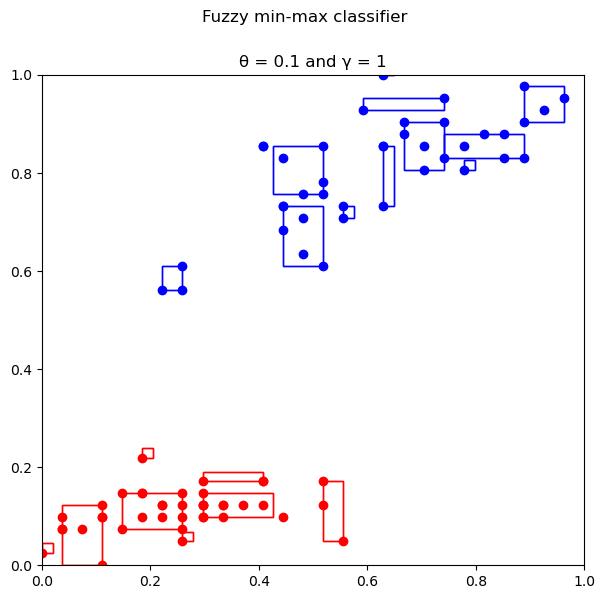

In [12]:
# save the training process in GIF format
_ = clf2.animate()

Now we load the saved GIF file and show in jupyter notebook


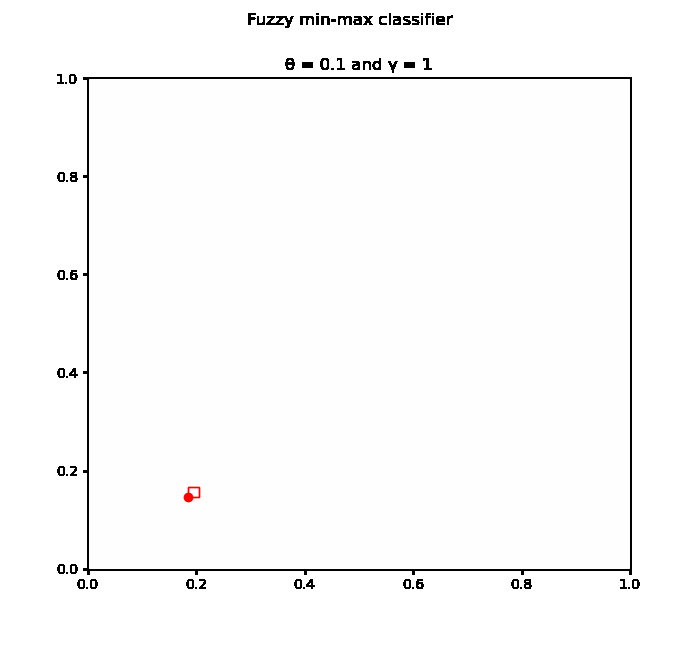

In [13]:
import io
import base64
from IPython.display import HTML

b64 = base64.b64encode(open('./fuzzy_animation.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))